<span style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">An Exception was encountered at '<a href="#papermill-error-cell">In [11]</a>'.</span>

In [1]:
from eoxhub import check_compatibility
check_compatibility("user-2022.10-14", dependencies=["SH"])



---------

The following environment variables are available:

* `SH_CLIENT_ID`, `SH_INSTANCE_ID`, `SH_CLIENT_NAME`, `SH_CLIENT_SECRET`


# Drought impact monitoring platform 

## EO based Digital Twin precursor of a spatio-temporal drought impact monitoring system in Europe 

_Eva Ivits<sup>1</sup>, Lars Eklundh<sup>2</sup>, Roel Van Hoolst<sup>3</sup>, Bruno Smets<sup>3</sup>, Hongxiao, Zhanzhang<sup>3</sup>, Grega Milcinski<sup>4</sup>, Anja Vrecko<sup>4</sup>, Maxim Lamare<sup>5</sup>_

 

1: European Environment Agency;
2: Lund University;
3: VITO;
4: Sinergise;
5: Sentinel Hub 


## Introduction

This Jupyter Notebook presents the workflow developped within the ESA funded Drought impact monitoring platform pilot project. The aim of the project was to develop a pan-European scale drought impact monitoring platform using the new CLMS service High Resolution Vegetation Phenology and Productivity (HR-VPP) derived from Sentinel 2 images. The 10m spatial resolution seasonal trajectories and phenology and productivity parameters were used for studying vegetation dynamics as a response to soil moisture deficit during the period 2017-2020 in Europe. The project was initially based on the workflow developed within the framework of the EEA Drought Impact Indicator (EEA 2021).  However, during the development phase of the project, the scientific principles governing the algorithms were consolidated and an entirely new workflow was proposed. 


This Jupyter Notebook demonstrates how to derive the following variables based on the MR-VPP and HR-VPP datasets:

- Soil moisture anomaly 

- Long Term Average soil moisture anomaly 

- Monthly drought hazard 

- Drought pressure 

- Drought pressure month 

- Drought pressure intensity 

- Long Term Average drought pressure intensity 

- LINT anomaly 

- Drought impact 

- Drought impact mask 

- Drought impact intensity 

- Drought impact intensity mask 

- TPROD anomaly 

- SPROD anomaly 

- Total drought impact 

- Seasonal drought impact 

- Number of Seasons


The variable are generated as raster files, accompanied by statistics aggregated by:

- Adminstrative area (NUTS3 regions)

- Land Cover type

- Land Cover flow


The workflow is designed to be run at the continental scale. However, for demonstration purposes, this example shows the workflow executed for a single NUTS3 region (Cádiz, Spain).

## Processing workflow

The following figure shows the processing workflow that is implemented in this Jupyter Notebook.

- Dark green boxes represent raster inputs.

- Light green boxes represent raster outputs.

- Dark grey boxes with a thick frame represent JSON outputs (statistics).


![Jupyter Notebook processing workflow](https://github.com/eurodatacube/notebooks/blob/master/notebooks/contributions/example_data/drought_monitoring/Drought_diagram.png?raw=true)



## Step 1: MR-VPP annual and monthly products

In a first step, we will compute the annual and monthly drought products based on Medium Resolution Vegetation Phenology and Productivity (MR-VPP).

In [2]:
# Sentinel Hub
from sentinelhub import (SHConfig, Geometry, SentinelHubRequest, DataCollection, MimeType, BBox, SentinelHubBatch, BatchRequestStatus)

# Geospatial
import geopandas as gpd
from shapely.geometry import shape, GeometryCollection

# Utilities
import json
import time
import datetime as dt
import os
import urllib3

### Credentials

We recommend the use of EDC built-in credentials for Sentinel Hub services.

In [3]:
# Set the Sentinel Hub credentials based on EDC managed credentials
config = SHConfig()
config.sh_client_id = os.environ["SH_CLIENT_ID"]
config.sh_client_secret = os.environ["SH_CLIENT_SECRET"]

# Change endpoint
config.sh_base_url  = "https://creodias.sentinel-hub.com"

### Read AOI

In the following cells we will specify the geoJSON of the AOI for Batch Processing. Here we will use the NUTS3 region of Cádiz in southern Spain.

In [4]:
# Open Json
fullaoi = gpd.read_file("https://raw.githubusercontent.com/eurodatacube/notebooks/master/notebooks/contributions/example_data/drought_monitoring/Cadiz.geojson")

# Buffer 500m to make sure the entire AOI is covered
buffered_aoi = fullaoi.iloc[0].geometry.buffer(500)

# Check number of vertices (Sentinel Hub can only process geometries with < 1500 nodes)
nodes = 0
for x in buffered_aoi.geoms:
    nodes += len(x.exterior.coords)

# If too many nodes, progressively simplify
sim_nr = 100

while nodes >= 1500:
    
    # Simplify geometry
    buffered_aoi = fullaoi.iloc[0].geometry.buffer(500).simplify(sim_nr)
    sim_nr += 100

    # Recompute nodes
    nodes = 0
    for x in buffered_aoi.geoms:
        nodes += len(x.exterior.coords)

cadiz_aoi = Geometry(buffered_aoi, crs="EPSG:3035")

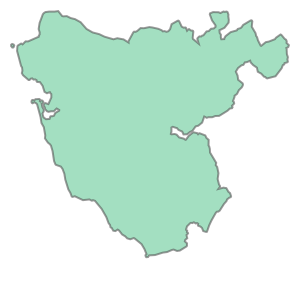

In [5]:
# Show the geometry
buffered_aoi

## Evalscript for MR-VPP 500m products

The workflow was written as an [Evalscript](https://docs.sentinel-hub.com/api/latest/evalscript/v3/) to enable large-scale processing using Batch API.

Here we will import the Evalscript and format it in a way suitable for use with Python:

- the variables `YEAR0` and `YEAR1` will be replaced by `{0}` and `{1}` for Python to pass the parameters
- the `{` and `}` in the Evalscript will be escaped to `{{` and `}}`

In [6]:
# Open evalscript
http = urllib3.PoolManager()
response = http.request('GET', "https://raw.githubusercontent.com/eurodatacube/notebooks/master/notebooks/contributions/example_data/drought_monitoring/mrvpp_500m_monthly_annual_raster_stats.js")
evalscript_mrvpp = response.data.decode('utf-8')

# Make replacements
evalscript_mrvpp = evalscript_mrvpp.replace('{', '{{')
evalscript_mrvpp = evalscript_mrvpp.replace('}', '}}')
evalscript_mrvpp = evalscript_mrvpp.replace('YEAR0', '{0}')
evalscript_mrvpp = evalscript_mrvpp.replace('YEAR1', '{1}')

## Run first Batch request

### Set CreoDIAS bucket name

Set the name of the bucket (that was [correctly setup](https://docs.sentinel-hub.com/api/latest/api/batch/#aws-bucket-settings)) where the results will be saved.

In [7]:
BUCKET_NAME = '<BUCKET-NAME>'

### Set input data collection IDs

For the first step, we will three input layers that are hosted on CreoDIAS / WEkEO. 

- [Soil moisture index and anomaly](https://edo.jrc.ec.europa.eu/documents/factsheets/factsheet_soilmoisture.pdf)
- [MR-VPP](https://www.eea.europa.eu/data-and-maps/data/copernicus-land-monitoring-service-medium)
- Statistical indices: a combination of [NUTS3](https://ec.europa.eu/eurostat/web/nuts/background), [CLCA](https://www.eea.europa.eu/data-and-maps/data/corine-land-cover-accounting-layers), and [Land Cover Flow 2000-2018](https://www.eea.europa.eu/data-and-maps/data/land-cover-flows-based-on).

Please contact us if you need access to these data collections: `info@sentinel-hub.com`.

In [8]:
# Set collection IDs for the input layers
soil_moisture_id = "<ID>"
mrvpp_timesat_id = "<ID>"
statistical_areas_id = "<ID>"

### Requests for Batch

In the next cell we prepare a function to run Batch Processing so that we can easily trigger over many years.

In [9]:
def run_batch_year(thisyear, aoi, evalscript, foldername, myconfig):
    
    print(f"Running Year {thisyear}")
        
    # Set timesat dates
    timesat_start_date = dt.date(thisyear, 1, 1)
    timesat_end_date = dt.date(thisyear, 1, 1)

    # Automatically calculate Soil moisture dates
    sm_start_date = timesat_start_date.replace(year=timesat_start_date.year-1)
    sm_end_date = dt.date(timesat_end_date.year, 12, 31)
    
    # Batch object
    batch = SentinelHubBatch(config=myconfig)
    
    # Make the outputs
    shresponses = [SentinelHubRequest.output_response(f'Monthly_Drought_Hazard_{x}_{y}', MimeType.TIFF) for y in range(1,12+1) for x in [str(thisyear-1), thisyear]]
    shresponses.append(SentinelHubRequest.output_response(f'Annual_Soil_Moisture_{thisyear}', MimeType.TIFF))
    shresponses.append(SentinelHubRequest.output_response(f'Annual_Drought_Pressure_{thisyear}', MimeType.TIFF))
    shresponses.append(SentinelHubRequest.output_response(f'Drought_Pressure_Month_{thisyear}', MimeType.TIFF))
    shresponses.append(SentinelHubRequest.output_response(f'Annual_Drought_Pressure_Intensity_{thisyear}', MimeType.TIFF))
    shresponses.append(SentinelHubRequest.output_response(f'LINT_anomaly_{thisyear}', MimeType.TIFF))
    shresponses.append(SentinelHubRequest.output_response(f'Drought_Impact_{thisyear}', MimeType.TIFF))
    shresponses.append(SentinelHubRequest.output_response(f'Drought_Impact_Mask_{thisyear}', MimeType.TIFF))
    shresponses.append(SentinelHubRequest.output_response(f'Drought_Impact_Intensity_{thisyear}', MimeType.TIFF))
    shresponses.append(SentinelHubRequest.output_response(f'Drought_Impact_Intensity_Mask_{thisyear}', MimeType.TIFF))
    shresponses.append(SentinelHubRequest.output_response(f'userdata', MimeType.JSON))

    
    # Make the request for Batch
    request_for_batch = SentinelHubRequest(
        evalscript=evalscript.format(str(thisyear-1), str(thisyear)),
        input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.define_byoc(soil_moisture_id),          
            identifier="SM",
            time_interval=(sm_start_date, sm_end_date),          
        ),
       SentinelHubRequest.input_data(
            data_collection=DataCollection.define_byoc(mrvpp_timesat_id),          
            identifier="TIMESAT",
            time_interval=(timesat_start_date, timesat_end_date),          
        ),
        SentinelHubRequest.input_data(
            data_collection=DataCollection.define_byoc(mrvpp_timesat_id),          
            identifier="TIMESATLONG",
            time_interval=(dt.date(2000, 1, 1), dt.date(2021, 1, 1)),          
        ),
        SentinelHubRequest.input_data(
            data_collection=DataCollection.define_byoc(statistical_areas_id),          
            identifier="INDICES",
            time_interval=(dt.date(2018, 1, 1), dt.date(2018, 1, 1)),          
        ),
    ],
        responses=shresponses,
        geometry=aoi,
        config=myconfig
    )
    
    # Create Batch request
    batch_request = batch.create(
        request_for_batch,
        tiling_grid=SentinelHubBatch.tiling_grid(
            grid_id=6,
            resolution=500,
            buffer=(0, 0)
        ),
        description=f'EEA MRVPP FULL 500m year {thisyear}',
        output = SentinelHubBatch.output(
        defaultTilePath = f"s3://{BUCKET_NAME}/{foldername}",
        cog_output = True,
        create_collection = False,
        cog_parameters = {"resamplingAlgorithm": "nearest"}
        )
    )
    
    time.sleep(15)
    
    batch_request = batch.get_request(batch_request)
    
    batch.start_analysis(batch_request)
    
    batch_request = batch.get_request(batch_request)
    
   
   
    batch_request = batch.get_request(batch_request)
    status = 0
    cnt = 0
    
    while status == 0:

        time.sleep(15)
        
        batch_request = batch.get_request(batch_request)

        if batch_request.status == BatchRequestStatus.ANALYSIS_DONE:
            status = 1
            failed = False
            print("Analysis done")
        elif batch_request.status == BatchRequestStatus.FAILED:
            status = 1
            failed = True
            print("Failed")
        elif batch_request.status == BatchRequestStatus.ANALYSING:
            status = 0
            print("Still analysing")
            time.sleep(5)
        else:
            status = 0
            time.sleep(5)
            cnt += 1
            print(f"Ping number: {cnt}")
        
    if not failed:
        batch_request = batch.get_request(batch_request)
        batch.start_job(batch_request)
        print(f"Running {batch_request.request_id}")
    else:
        raise RuntimeError("Batch failed to analyse")
    batch_request = batch.get_request(batch_request)    
    return batch_request.request_id

### Run the Batch Processing

In [10]:
# Collect information about the Batch Process in a list
ids = []

<span id="papermill-error-cell" style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">Execution using papermill encountered an exception here and stopped:</span>

In [11]:
# Loop from 2000 to 2003 for this example
for x in list(range(2000, 2022)):
    ids.append(run_batch_year(x, cadiz_aoi, evalscript_mrvpp, "MRVPP_FULL_ANNUAL_MONTHLY", config))

Running Year 2000


DownloadFailedException: Failed to download from:
https://creodias.sentinel-hub.com/api/v1/batch/process
with HTTPError:
400 Client Error: Bad Request for url: https://creodias.sentinel-hub.com/api/v1/batch/process
Server response: "Unsupported type: byoc-<ID>
 at [Source: (org.glassfish.jersey.message.internal.ReaderInterceptorExecutor$UnCloseableInputStream); line: 1, column: 17424] (through reference chain: com.sinergise.sentinel.batch.api.BatchProcessRequest["processRequest"]->com.sinergise.sentinel.api.process.request.ProcessRequest["input"]->com.sinergise.sentinel.api.process.request.Input["data"]->java.util.ArrayList[0])"

## Step 2: MR-VPP long term average products

In a second step, we will compute the long term average drought products based on the Medium Resolution Vegetation Phenology and Productivity (MR-VPP) products.

### Set input data collection IDs

For the second step, we will reuse three input layers defined in step 1. 


### Evalscript for MR-VPP 500m products

The workflow was written as an [Evalscript](https://docs.sentinel-hub.com/api/latest/evalscript/v3/) to enable large-scale processing using Batch API.

Here we will import the Evalscript:

In [ ]:
# Open evalscript
http = urllib3.PoolManager()
response = http.request('GET', "https://raw.githubusercontent.com/eurodatacube/notebooks/master/notebooks/contributions/example_data/drought_monitoring/mrvpp_500m_lta_raster_stats.js")
evalscript_mrvpp_lta = response.data.decode('utf-8')

### Create Batch Request

In [ ]:
# Set dates for full range
start_date = dt.date(2000, 1, 1)
end_date = dt.date(2021, 1, 1)

# Batch object
batch = SentinelHubBatch(config=config)

request_for_batch = SentinelHubRequest(
    evalscript=evalscript_mrvpp_lta,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.define_byoc(soil_moisture_id),          
            identifier="SM",
            time_interval=(start_date, end_date),          
        ),
        SentinelHubRequest.input_data(
            data_collection=DataCollection.define_byoc(mrvpp_timesat_id),          
            identifier="TIMESAT",
            time_interval=(start_date, end_date),          
        ),
        SentinelHubRequest.input_data(
            data_collection=DataCollection.define_byoc(statistical_areas_id),          
            identifier="INDICES",
            time_interval=(dt.date(2018, 1, 1), dt.date(2018, 1, 1)),          
        ),
    ],
    responses=[SentinelHubRequest.output_response('Long_Term_Soil_Moisture', MimeType.TIFF),
               SentinelHubRequest.output_response('Long_Term_Drought_Pressure_Intensity', MimeType.TIFF),
               SentinelHubRequest.output_response(f'userdata', MimeType.JSON)
              ],
    geometry=andalusia_aoi,
    config=config
)

# Create Batch request
batch_request = batch.create(
    request_for_batch,
    tiling_grid=SentinelHubBatch.tiling_grid(
        grid_id=6,
        resolution=500,
        buffer=(0, 0)
    ),
    description=f'EEA 500m Long Term Average',
    output = SentinelHubBatch.output(
    defaultTilePath = f"s3://{BUCKET_NAME}/MRVPP_FULL_LTA",
    cog_output = True,
    create_collection = False,
    cog_parameters = {"resamplingAlgorithm": "nearest"}
    )
)

batch_request = batch.get_request(batch_request)

print(batch_request)

In [ ]:
# Analyse the request
batch.start_analysis(batch_request)

time.sleep(45)

batch_request = batch.get_request(batch_request)
print(batch_request)

### Run Batch Request

In [ ]:
batch.start_job(batch_request)

## Step 3: HR-VPP products

In the third step, we will compute the products derived from the High Resolution Vegetation Phenology and Productivity (HR-VPP) layers at 10m resolution. The products are derived from a combination of HR-VPP, and the products computed in the previous steps.

### Set input data collection IDs

For the last step, we will use four input layers that are hosted on CreoDIAS / WEkEO. 

- [HR-VPP season 1](https://land.copernicus.eu/pan-european/biophysical-parameters/high-resolution-vegetation-phenology-and-productivity): the data for the first season of each year.
- [HR-VPP season 2](https://land.copernicus.eu/pan-european/biophysical-parameters/high-resolution-vegetation-phenology-and-productivity): the data for the second season of each year.
- Statistical indices: a combination of [NUTS3](https://ec.europa.eu/eurostat/web/nuts/background), [CLCA](https://www.eea.europa.eu/data-and-maps/data/corine-land-cover-accounting-layers), and [Land Cover Flow 2000-2018](https://www.eea.europa.eu/data-and-maps/data/land-cover-flows-based-on).
- Previous Yearly MR-VPP results. After running the first steps, the results need to be ingested as [BYOC layers](https://docs.sentinel-hub.com/api/latest/api/byoc/) in CreoDIAS / WEkEO.

Please contact us if you need access to these data collections: `info@sentinel-hub.com`.

In [ ]:
# Set collection IDs for the input layers
hrvpp_s1_id = "<ID>"
hrvpp_s2_id = "<ID>"
statistical_areas_id = "<ID>"
mrvpp_outputs_id = "<ID>"

## Evalscript for MR-VPP 500m products

The workflow was written as an [Evalscript](https://docs.sentinel-hub.com/api/latest/evalscript/v3/) to enable large-scale processing using Batch API.

Here we will import the Evalscript and format it in a way suitable for use with Python:

- the variables `YEAR0` will be replaced by `{0}` for Python to pass the parameters
- the `{` and `}` in the Evalscript will be escaped to `{{` and `}}`

In [ ]:
# Open evalscript
http = urllib3.PoolManager()
response = http.request('GET', "https://raw.githubusercontent.com/eurodatacube/notebooks/master/notebooks/contributions/example_data/drought_monitoring/hrvpp_10m_raster_stats.js")
evalscript_hrvpp = response.data.decode('utf-8')

# Make replacements
evalscript_hrvpp = evalscript_mrvpp.replace('{', '{{')
evalscript_hrvpp = evalscript_mrvpp.replace('}', '}}')
evalscript_hrvpp = evalscript_mrvpp.replace('YEAR0', '{0}')

### Requests for Batch

In the next cell we prepare a function to run Batch Processing so that we can easily trigger over many years.

In [ ]:
def run_batch_year(inyear, aoi, evalscript, BUCKET_NAME, FOLDER_NAME, myconfig):
        
    # Set timesat dates
    start_date = dt.date(2017, 1, 1)
    end_date = dt.date(2021, 1, 1)

    # Batch object
    batch = SentinelHubBatch(config=myconfig)
    
    # Test make the outputs for Process API
    shresponses = [SentinelHubRequest.output_response(f'TPROD_minmax_{inyear}', MimeType.TIFF)]
    shresponses.append(SentinelHubRequest.output_response(f'SPROD_minmax_{inyear}', MimeType.TIFF))
    shresponses.append(SentinelHubRequest.output_response(f'Total_Drought_Impact_{inyear}', MimeType.TIFF))
    shresponses.append(SentinelHubRequest.output_response(f'Seasonal_Drought_Impact_{inyear}', MimeType.TIFF))
    shresponses.append(SentinelHubRequest.output_response(f'Season_Length_{inyear}', MimeType.TIFF))
    shresponses.append(SentinelHubRequest.output_response(f'Nb_Seasons_{inyear}', MimeType.TIFF))
    shresponses.append(SentinelHubRequest.output_response(f'MR_drought_impact_{inyear}', MimeType.TIFF))
    shresponses.append(SentinelHubRequest.output_response('userdata', MimeType.JSON))

    
    # Make the request for Batch
    request_for_batch = SentinelHubRequest(
        evalscript=evalscript.format(inyear),
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=DataCollection.define_byoc(mrvpp_outputs_id),          
                identifier="MRVPP",
                time_interval=(f'{inyear}-01-01', f'{inyear}-01-01'),          
            ),
           SentinelHubRequest.input_data(
                data_collection=DataCollection.define_byoc(hrvpp_s1_id),          
                identifier="VPP1",
                time_interval=(start_date, end_date),          
            ),
           SentinelHubRequest.input_data(
                data_collection=DataCollection.define_byoc(hrvpp_s2_id),          
                identifier="VPP2",
                time_interval=(start_date, end_date),          
            ),
            SentinelHubRequest.input_data(
                    data_collection=DataCollection.define_byoc(statistical_areas_id),          
                    identifier="INDICES",
                    time_interval=('2018-01-01', '2018-01-01'),          
                ),
        ],
        responses=shresponses,
        geometry=aoi,
        config=config
    )

    # Create Batch request
    batch_request = batch.create(
        request_for_batch,
        tiling_grid=SentinelHubBatch.tiling_grid(
            grid_id=7,
            resolution=10,
            buffer=(0, 0)
        ),
        description=f'EEA FULL RUN 10m year {inyear}',
        output = SentinelHubBatch.output(
        defaultTilePath = f"s3://{BUCKET_NAME}/{FOLDER_NAME}",
        cog_output = True,
        create_collection = False,
        cog_parameters = {"resamplingAlgorithm": "nearest"}
        )
    )
    
    time.sleep(15)
    
    batch_request = batch.get_request(batch_request)

    print(batch_request)
    
    batch.start_analysis(batch_request)
    
    batch_request = batch.get_request(batch_request)
    
   
   
    batch_request = batch.get_request(batch_request)
    status = 0
    
    
    while status == 0:

        time.sleep(15)
        
        batch_request = batch.get_request(batch_request)

        if batch_request.status == BatchRequestStatus.ANALYSIS_DONE:
            status = 1
            failed = False
            print("Analysis done")
        elif batch_request.status == BatchRequestStatus.FAILED:
            status = 1
            failed = True
            print("Failed")
        elif batch_request.status == BatchRequestStatus.ANALYSING:
            status = 0
            print("Still analysing")
            time.sleep(5)
        else:
            print("Other status")
            status = 0
            time.sleep(5)
        
    if not failed:
        batch_request = batch.get_request(batch_request)
        batch.start_job(batch_request)
        print(f"Running {batch_request.request_id}")
    else:
        raise RuntimeError("Batch failed to analyse")
    batch_request = batch.get_request(batch_request)    
    return batch_request.request_id

### Run the Batch Processing

In [ ]:
# Collect information about the Batch Process in a list
ids = []

In [ ]:
# Loop from 2017 to 2020 for this example
for x in list(range(2017, 2021)):
    ids.append(run_batch_year(x, andalusia_aoi, evalscript_hrvpp_avg, BUCKET_NAME, "HRVPP_FULL", config))